In [4]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files

!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

In [6]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [7]:
# checking the directories from the root PATH to understand the file structure for train_image_generator
for root, dirs, _ in os.walk(PATH):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print("-"*40)

Root: cats_and_dogs
Dirs: ['test', 'validation', 'train']
----------------------------------------
Root: cats_and_dogs/test
Dirs: []
----------------------------------------
Root: cats_and_dogs/validation
Dirs: ['cats', 'dogs']
----------------------------------------
Root: cats_and_dogs/validation/cats
Dirs: []
----------------------------------------
Root: cats_and_dogs/validation/dogs
Dirs: []
----------------------------------------
Root: cats_and_dogs/train
Dirs: ['cats', 'dogs']
----------------------------------------
Root: cats_and_dogs/train/cats
Dirs: []
----------------------------------------
Root: cats_and_dogs/train/dogs
Dirs: []
----------------------------------------


In [8]:
# 3
train_image_generator = ImageDataGenerator(rescale=1. / 255)
validation_image_generator = ImageDataGenerator(rescale=1. / 255)
test_image_generator = ImageDataGenerator(rescale=1. / 255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='binary')  # binary because we only have two classes so we can use output size = 1 and have 0 and 1 for the classes
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    classes=['test'],  # since the path for test doesn't have a folder for cats and other one for dogs, we create a dummy class to treat all images in test as one class
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [9]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])              # cuties get plotted here (:


In [10]:
# 5 --> TRANSFORMATIONS for **data augmentation** since there's a small number of training examples. We need more to prevent overfitting to those few examples.
# asking for 4-6 transformations so we do 6 bc why not
train_image_generator = ImageDataGenerator(rescale=1. / 255,  # rescale obvi
                                           horizontal_flip=True,
                                           height_shift_range=0.1,
                                           width_shift_range=0.1,
                                           brightness_range=(0.5,1.5),
                                           zoom_range = [1, 1.5],
                                           rotation_range=10)

In [27]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)    # same cutie different fonts

Found 2000 images belonging to 2 classes.


In [28]:
# 7
model = Sequential()

# we have imported: Dense, Conv2D, Flatten, Dropout, MaxPooling2D
# let's use add here instead of creating it with the contructor

# parameters for easier change
kernel = 3
pooling = 2
dropout = 0.5

# ------------ LAYERS ------------ #
# convolutions
model.add(Conv2D(32, kernel, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # input shape needs to be the img dimensions
model.add(MaxPooling2D(pooling))
model.add(Conv2D(64, kernel, activation='relu'))
model.add(MaxPooling2D(pooling))

# dense layers
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# we compile with the optimizer and loss, also metrics arg to view acc per epoch. since it's two classes we can use binary_crossentropy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# 8

history = model.fit(x=train_data_gen,
                    epochs=epochs,
                    validation_data=val_data_gen
                    )

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5025 - loss: 1.1232 - val_accuracy: 0.5360 - val_loss: 0.6887
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5330 - loss: 0.6852 - val_accuracy: 0.6480 - val_loss: 0.6611
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6063 - loss: 0.6593 - val_accuracy: 0.6620 - val_loss: 0.6359
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6189 - loss: 0.6485 - val_accuracy: 0.6370 - val_loss: 0.6269
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6667 - loss: 0.6134 - val_accuracy: 0.6670 - val_loss: 0.6081
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6600 - loss: 0.6109 - val_accuracy: 0.6550 - val_loss: 0.6014
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6794 - loss: 0.6026 - val_accuracy: 0.6910 - val_loss: 0.5845
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6793 - loss: 0.6004 - val_accuracy: 0.7000 - val_loss:

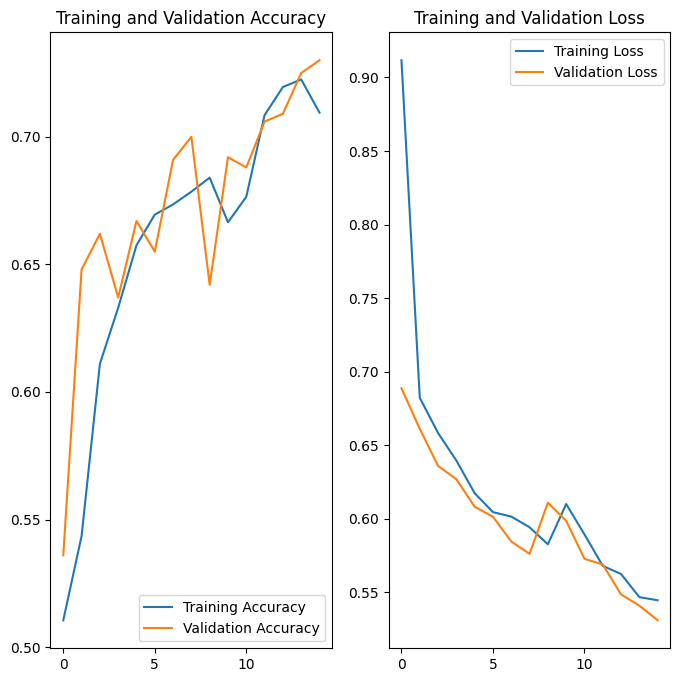

In [30]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
[0.42730972170829773, 0.3551650941371918, 0.06678866595029831, 0.9529691338539124, 0.41689223051071167, 0.5276432037353516, 0.7217109203338623, 0.27188926935195923, 0.506420373916626, 0.9586130380630493, 0.34407511353492737, 0.5131731629371643, 0.181893989443779, 0.2865423262119293, 0.4523695111274719, 0.6192296743392944, 0.4034861624240875, 0.877041757106781, 0.6433415412902832, 0.4735981523990631, 0.11736811697483063, 0.7199380397796631, 0.2785274088382721, 0.524253785610199, 0.7318615913391113, 0.20740339159965515, 0.6977674961090088, 0.52314293384552, 0.4430927038192749, 0.5335436463356018, 0.21494705975055695, 0.22175486385822296, 0.9457123875617981, 0.999982476234436, 0.2369990050792694, 0.7463773488998413, 0.9986975193023682, 0.5918797254562378, 0.5306527018547058, 0.45956841111183167, 0.37910404801368713, 0.2790045142173767, 0.887529730796814, 0.5133294463157654, 0.22508759796619415, 0.2162853628396988, 0.4278440773487091, 0.41236096620559

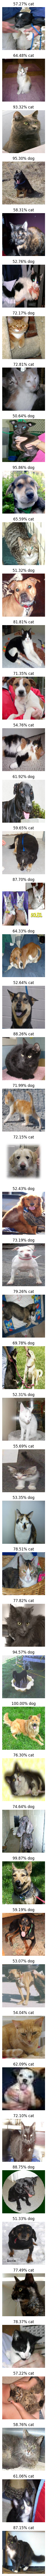

In [31]:
test_images, _ = next(test_data_gen)
probabilities = model.predict(test_data_gen).reshape(-1).tolist() # [[p1] [p2] [p3]] --reshape--> [p1 p2 p3 p4] --tolist--> [p1, p2, p3, p4]
print(probabilities)  # this way we obtain an array to compare the answers with [p1,p2,p3,...] and not [[p1],[p2],[p3]]

plotImages(test_images,probabilities=probabilities)

In [32]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
